In [1]:
from nanodrivers.visa_drivers.anapico import ANAPICO
from nanodrivers.visa_drivers.SIM928_voltage_source import SIM # as DC
from nanodrivers.visa_drivers.vna import VNA
from nanodrivers.visa_drivers.dc import DC
from nanodrivers.visa_drivers.signal_analyser import Anri

#math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit

#plotting
import matplotlib.pyplot as plt
import matplotlib

#matlab import
import scipy.io
from scipy.io import savemat, loadmat
from scipy.optimize import minimize
from scipy.fft import fft, ifft, fftshift, ifftshift


#file_store
import os

#time
import time
from datetime import datetime, timedelta


from ctypes import *
%matplotlib inline

Global_data_adress = r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA"
exp_name = 'TWPA_noise_9'
adress = Global_data_adress+'\\'+exp_name
if not os.path.exists(adress):
  os.mkdir(adress)
  print("Folder %s created!" % adress)
else:
  print("Folder %s already exists" % adress)

C:\Users\Demag\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Folder C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9 already exists


In [2]:
dc = SIM(slot_num=7)
dc.idn()

Unable to connect device.
 VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.
Check that device is connected, visible in NI MAX and is not used by another software.
Connection exist: Stanford_Research_Systems,SIM928,s/n035459,ver2.7



In [3]:
dc.disconnect()

SIM928 is now disconnected from SIM900 mainframe


In [4]:
dc = SIM(slot_num=7)
dc.idn()

Connection exist: Stanford_Research_Systems,SIM928,s/n035459,ver2.7



In [5]:
vna = VNA()
vna.idn()

Connection exist: Rohde-Schwarz,ZNB20-2Port,1311601062102129,3.45



In [11]:
anapico = ANAPICO()
anapico.idn()

Connection exist: AnaPico AG,APMS20G,3C6-0B4F40003-0985,1.0.7



In [32]:
anapico.set_off(1)
anapico.set_off(3)
anapico.set_off(4)

In [7]:
sa = Anri('TCPIP::169.254.36.112::INSTR')
print(sa.idn())

def set_cent_freq_(sa, freq): 
    sa.write('FREQuency:CENTer {} MHz'.format(freq/1e6))
    
    
def set_span_(sa, span):
    sa.write('FREQ:SPAN {}'.format(span))
    
def set_band_(sa, band):
    sa.write('BAND {}KHZ'.format(str(band)))
    
def get_freq_(sa):
    nop = int(sa.query('SWEep:POINts?'))
    start_fr = sa.query_float('FREQuency:STARt?')
    stop_fr = sa.query_float('FREQuency:STOP?')
    return np.linspace(start_fr, stop_fr, nop)

def get_data_(sa): 
    sa.write('INIT:IMM')
    time.sleep(20 + sa.query_float('SWEep:TIME?'))
    raw_data = sa.query('TRAC:DATA? TRACE1')
    return np.array(raw_data.split(','), dtype=float)

Connection exist: Rohde&Schwarz,FPL1026,1304.0004K26/200025,2.10SP1

None


# Power sweep

In [21]:
path = adress +'\\'+ 'IM'
if not os.path.exists(path):
  os.mkdir(path)
  print("Folder %s created!" % path)
else:
  print("Folder %s already exists" % path)

Folder C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9\IM already exists


In [30]:
state = dict()

low_noise_pump_freq = 4.605e9*2
low_noise_DC = 1.606
low_noise_pump_power = 8 # at low powers for some reason some IM stuff comes up
state['low_noise_pump_freq'] = low_noise_pump_freq
state['low_noise_DC'] = low_noise_DC
state['low_noise_pump_power'] = low_noise_pump_power

anapico.set_freq(1, low_noise_pump_freq)
anapico.set_power(1, low_noise_pump_power)
anapico.set_on(1)
dc.set_volt(low_noise_DC)
dc.set_on()

delta_max = 0.01e9
low_noise_pump_freq_IM1 = 4.61327e9-delta_max
low_noise_pump_freq_IM2 = 4.61327e9+delta_max
low_noise_IM_power = np.linspace(-20, -5, 11)
state['low_noise_pump_freq_IM1'] = low_noise_pump_freq_IM1
state['low_noise_pump_freq_IM2'] = low_noise_pump_freq_IM2
state['low_noise_IM_power'] = low_noise_IM_power
state['delta_max'] = delta_max

anapico.set_freq(3, low_noise_pump_freq_IM1)
anapico.set_power(3, low_noise_IM_power[0])
anapico.set_on(3)

anapico.set_freq(4, low_noise_pump_freq_IM2)
anapico.set_power(4, low_noise_IM_power[0])
anapico.set_on(4)

state['band_KHz'] = 0.01
set_band_(sa, 0.01)
state['cent_freq_sa'] = low_noise_pump_freq/2
set_cent_freq_(sa, low_noise_pump_freq/2)
state['span_sa_GHz'] = 0.4
set_span_(sa, 0.4e9)
state['freq'] = get_freq_(sa)
spectra = np.zeros((len(low_noise_IM_power), len(get_freq_(sa))))

start_time = datetime.now()

file_name_o = 'IM_power_sweep_9GHzLOWnoise_with_BP_filter'
file_name = path + '\\' + file_name_o + start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.mat'
savemat(file_name, state)

for idx_IM_p in range(len(low_noise_IM_power)):
    start_run_time = datetime.now()
    print(start_run_time.strftime(r'%Y-%m-%d %H:%M:%S-->'), idx_IM_p)
    anapico.set_power(3, low_noise_IM_power[idx_IM_p])
    anapico.set_power(4, low_noise_IM_power[idx_IM_p])
    spectra[idx_IM_p] = get_data_(sa)
    
    state['spectra'] = spectra
    savemat(file_name, state)
    

2025-06-21 17:57:56--> 0
2025-06-21 17:59:32--> 1
2025-06-21 18:01:09--> 2
2025-06-21 18:02:45--> 3
2025-06-21 18:04:21--> 4
2025-06-21 18:05:58--> 5
2025-06-21 18:07:34--> 6
2025-06-21 18:09:11--> 7
2025-06-21 18:10:47--> 8
2025-06-21 18:12:24--> 9
2025-06-21 18:14:00--> 10


# different points

In [ ]:
DC_points = np.linspace(1.2, 1.7, 20)
pump_points = np.linspace(9, 11.5, 2001)*1e9

for idx_DC_points in range(len(DC_points)):
    for idx_points in range(len(pump_points)):
        state = dict()

        low_noise_pump_freq = pump_points[idx_points]
        low_noise_DC = DC_points[idx_DC_points]
        low_noise_pump_power = 8 # at low powers for some reason some IM stuff comes up
        state['low_noise_pump_freq'] = low_noise_pump_freq
        state['low_noise_DC'] = low_noise_DC
        state['low_noise_pump_power'] = low_noise_pump_power

        anapico.set_freq(1, low_noise_pump_freq)
        anapico.set_power(1, low_noise_pump_power)
        anapico.set_on(1)
        dc.set_volt(low_noise_DC)
        dc.set_on()

        delta_max = 0.01e9
        low_noise_pump_freq_IM1 = 4.61327e9-delta_max
        low_noise_pump_freq_IM2 = 4.61327e9+delta_max
        low_noise_IM_power = np.linspace(-25, -10, 11)
        state['low_noise_pump_freq_IM1'] = low_noise_pump_freq_IM1
        state['low_noise_pump_freq_IM2'] = low_noise_pump_freq_IM2

        state['DC_points'] = DC_points
        state['pump_points'] = pump_points
        state['DC_points_curr'] = DC_points[idx_DC_points]
        state['pump_points_curr'] = freq = pump_points[idx_points]

        state['low_noise_IM_power'] = low_noise_IM_power
        state['delta_max'] = delta_max

        anapico.set_freq(3, low_noise_pump_freq_IM1)
        anapico.set_power(3, low_noise_IM_power[0])
        anapico.set_on(3)

        anapico.set_freq(4, low_noise_pump_freq_IM2)
        anapico.set_power(4, low_noise_IM_power[0])
        anapico.set_on(4)

        state['band_KHz'] = 0.0005
        set_band_(sa, 0.0005)
        state['cent_freq_sa'] = low_noise_pump_freq/2
        set_cent_freq_(sa, low_noise_pump_freq/2)
        state['span_sa_GHz'] = 0.5
        set_span_(sa, 0.5e9)
        state['freq'] = get_freq_(sa)
        spectra = np.zeros((len(low_noise_IM_power), len(get_freq_(sa))))

        start_time = datetime.now()

        file_name_o = 'IM_power_sweep_9GHzLOWnoise_no_BP_filter_' + str(idx_DC_points) + '_' + str(idx_points)
        file_name = path + '\\' + file_name_o + start_time.strftime(r'_%Y-%m-%d-%H-%M-%S') + '.mat'
        savemat(file_name, state)

        for idx_IM_p in range(len(low_noise_IM_power)):
            start_run_time = datetime.now()
            print(start_run_time.strftime(r'%Y-%m-%d %H:%M:%S-->'), idx_IM_p)
            anapico.set_power(3, low_noise_IM_power[idx_IM_p])
            anapico.set_power(4, low_noise_IM_power[idx_IM_p])
            spectra[idx_IM_p] = get_data_(sa)

            state['spectra'] = spectra
            savemat(file_name, state)

2025-06-21 18:36:39--> 0
2025-06-21 18:43:22--> 1
2025-06-21 18:50:04--> 2
2025-06-21 18:56:46--> 3
2025-06-21 19:03:29--> 4
2025-06-21 19:10:11--> 5
2025-06-21 19:16:54--> 6
2025-06-21 19:23:36--> 7
2025-06-21 19:30:18--> 8
2025-06-21 19:37:01--> 9
2025-06-21 19:43:43--> 10
2025-06-21 19:50:26--> 0
2025-06-21 19:57:08--> 1
2025-06-21 20:03:51--> 2
2025-06-21 20:10:33--> 3
2025-06-21 20:17:15--> 4
2025-06-21 20:23:58--> 5
2025-06-21 20:30:40--> 6
2025-06-21 20:37:21--> 7
2025-06-21 20:44:04--> 8
2025-06-21 20:50:46--> 9
2025-06-21 20:57:28--> 10
2025-06-21 21:04:11--> 0
2025-06-21 21:10:54--> 1
2025-06-21 21:17:36--> 2
2025-06-21 21:24:18--> 3
2025-06-21 21:31:01--> 4
2025-06-21 21:37:43--> 5
2025-06-21 21:44:25--> 6
2025-06-21 21:51:08--> 7
2025-06-21 21:57:50--> 8
2025-06-21 22:04:33--> 9
2025-06-21 22:11:15--> 10
2025-06-21 22:17:58--> 0
2025-06-21 22:24:40--> 1
2025-06-21 22:31:23--> 2
2025-06-21 22:38:05--> 3
2025-06-21 22:44:47--> 4
2025-06-21 22:51:30--> 5
2025-06-21 22:58:12-->

In [67]:
sa.query_float('FREQuency:STARt?')

4950000000.0

In [68]:
freq = get_freq_(sa)
data = get_data_(sa)

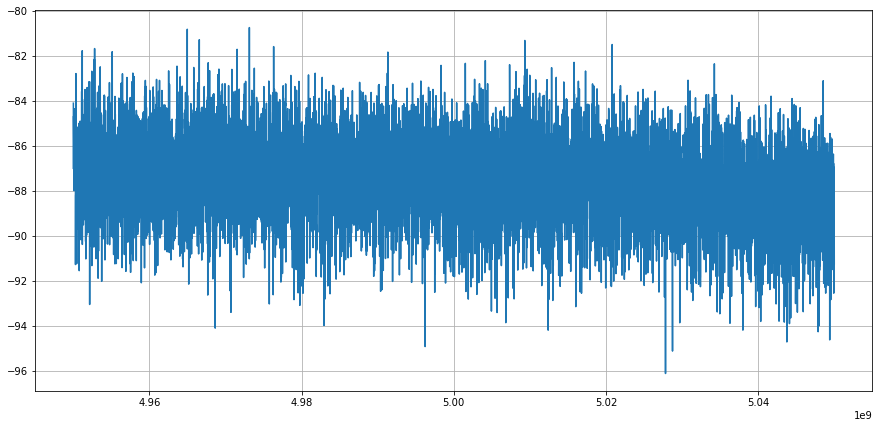

In [69]:
fig, ax = plt.subplots(figsize = (15,7))
ax.plot(freq, data)
# ax.axvline(low_noise_pump_freq/2,  color = 'g')
ax.grid()

# Intermodulation products

In [355]:
low_noise_pump_freq = 4.605e9*2
low_noise_DC = 1.606
low_noise_pump_power = 8 # at low powers for some reason some IM stuff comes up

delta_max = 0.01e9
low_noise_pump_freq_IM1 = 4.61327e9-delta_max
low_noise_pump_freq_IM2 = 4.61327e9+delta_max
low_noise_pump_power = 8


print(low_noise_pump_freq/1e9 - low_noise_pump_freq_IM1/1e9)

4.606730000000001


In [348]:
anapico.set_freq(1, low_noise_pump_freq)
anapico.set_power(1, low_noise_pump_power)
dc.set_volt(low_noise_DC)
dc.set_on()
anapico.set_on(1)

In [368]:
anapico.set_freq(3, low_noise_pump_freq_IM1)
anapico.set_power(3,-25)
anapico.set_on(3)

anapico.set_freq(4, low_noise_pump_freq_IM2)
anapico.set_power(4,-25)
anapico.set_on(4)

In [366]:
anapico.set_off(3)
anapico.set_off(4)

# Test gain + no IM for just pump

In [298]:
dc.set_volt(low_noise_DC)
dc.set_on()

vna.set_band(10000)
vna.set_nop(10001)
vna.set_start_freq(4.2e9)
vna.set_stop_freq(8.5e9)
freq_gain_sweep = vna.get_freq()

anapico.set_off(1)
mag_ref, pha_ref = vna.get_data()

In [299]:
anapico.set_freq(1, low_noise_pump_freq)
anapico.set_power(1, 7.5)
anapico.set_on(1)
mag_on, pha_on = vna.get_data()

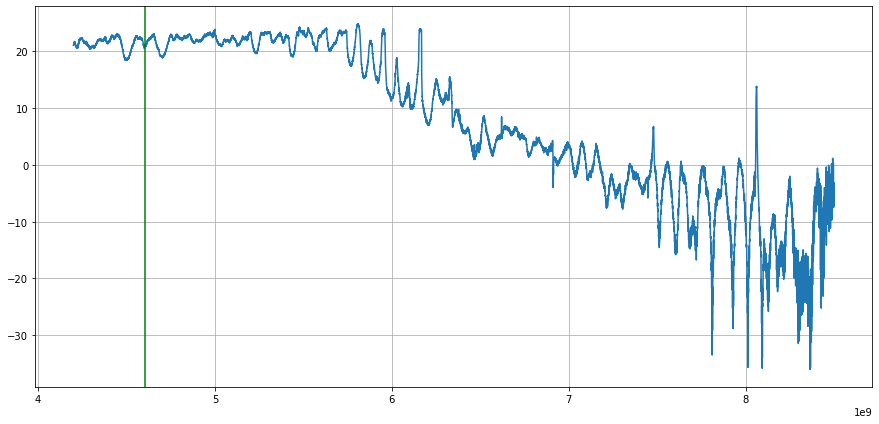

In [300]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15,7))
ax.plot(freq_gain_sweep, mag_on-mag_ref)
ax.axvline(low_noise_pump_freq/2,  color = 'g')
ax.grid()

In [301]:
anapico.set_off(1)

In [302]:
state = dict()
state['freq'] = freq_gain_sweep
state['mag_on'] = mag_on
state['mag_ref'] = mag_ref
state['pha_on'] = pha_on
state['pha_ref'] = pha_ref

file_name = path + '\\' + 'TWPA_gain_at_low_freq_point_full_sweep_4.614.mat'
savemat(file_name, state)

# Get BP filter profile

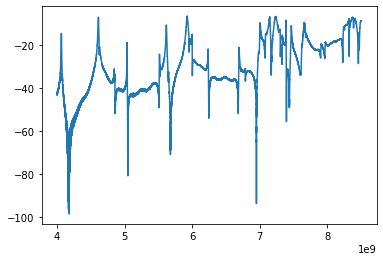

In [118]:
mag_filter, pha_filter = vna.get_data()
plt.plot(vna.get_freq(), mag_filter)

state = dict()
state['freq'] = vna.get_freq()
state['mag'] = mag_filter
state['pha'] = pha_filter
state['power'] = vna.get_power()

file_name = path + '\\' + 'BP_filter_scan_4.614.mat'
savemat(file_name, state)

# load BP profile

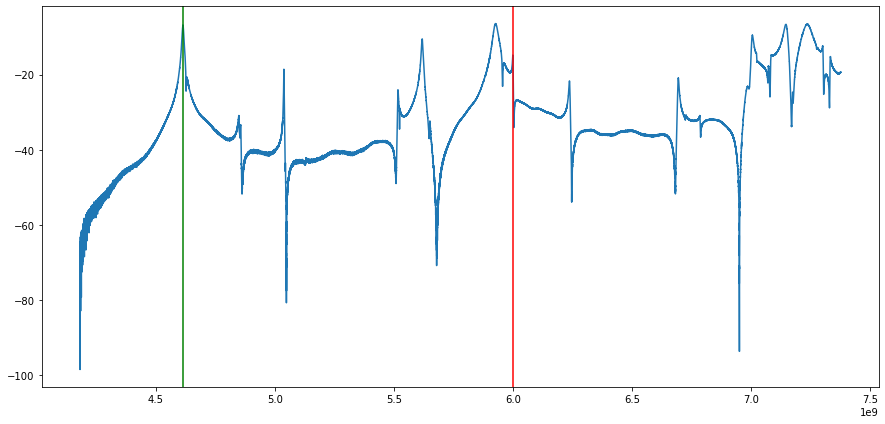

In [155]:
file_name = path + '\\' + 'BP_filter_scan_4.614.mat'
mat_low19 = loadmat(file_name)
freq_bp = mat_low19['freq'][0]
mag_bp = mat_low19['mag'][0]
pha_bp = mat_low19['pha'][0]

fig, ax = plt.subplots(figsize = (15,7))
ax.plot(freq_bp[4000:-25000], mag_bp[4000:-25000])
# ax.plot(freq_bp, mag_bp)
ax.axvline(low_noise_pump_freq/2,  color = 'g')
ax.axvline(6e9, color = 'r')

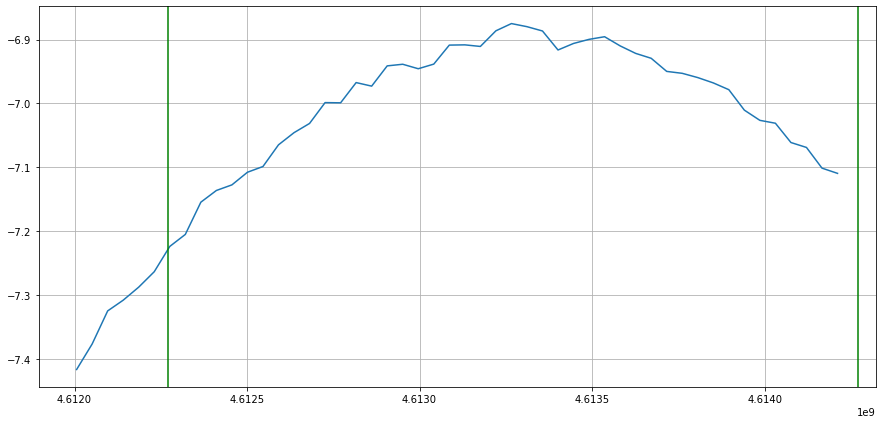

In [353]:
file_name = path + '\\' + 'BP_filter_scan_4.614.mat'
mat_low19 = loadmat(file_name)
freq_bp = mat_low19['freq'][0]
mag_bp = mat_low19['mag'][0]
pha_bp = mat_low19['pha'][0]

fig, ax = plt.subplots(figsize = (15,7))
ax.plot(freq_bp[13600:-86350], mag_bp[13600:-86350])
ax.axvline(low_noise_pump_freq_IM1,  color = 'g')
ax.axvline(low_noise_pump_freq_IM2,  color = 'g')
ax.grid()

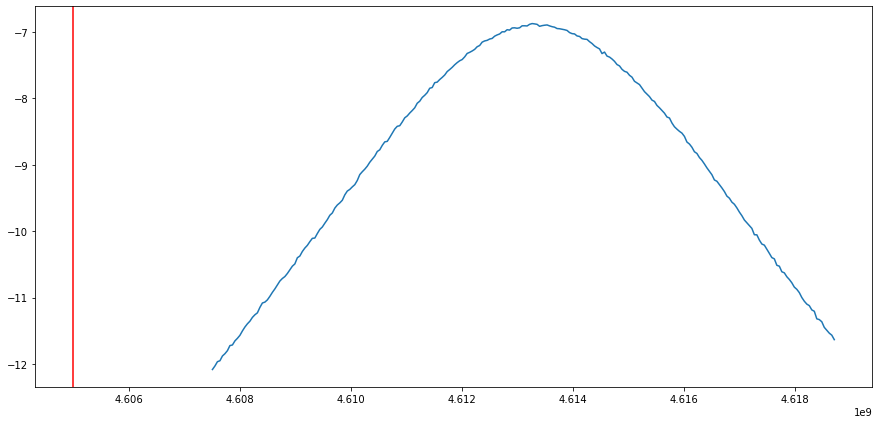

In [307]:
fig, ax = plt.subplots(figsize = (15,7))
ax.plot(freq_bp[13500:-86250], mag_bp[13500:-86250])
ax.axvline(low_noise_pump_freq/2,  color = 'r')